# **GIS × Python Tutorial 8.1 ~KMLとは & fastkml入門~**

<br>

## **はじめに**
---
この記事は「GIS × Python Tutorial」の関連記事です。

今回の`8.x`では `GeoPandas.GeoDataFrame`のクラスを拡張して、スタイルを定義したKMLを出力する新たなクラスを作成してみたいと思います。GeoDataFrame ではすでに `GeoDataFrame.to_file` で KML を出力する事が可能ですが、せっかく自由度が高い KML を使用するのであれば、スタイルを定義して KML を出力したいと思いこの記事を書いています。

チュートリアルは以下の順番で進んで行きます。

 - [8.1] "kmlとは" & "fastkml での KML 作成"

 - [8.2] GeoDataFrame の継承と独自メソッドの追加

<br>

## **1. KML**
---

### **1-1. KMLファイルとは**

**KML（Keyhole Markup Language）** とは、地理空間データを表現する為のXMLベースのファイルフォーマットです。KMLは"GoogleEarth"や"GoogleMaps"、その他様々な GIS アプリケーションで使用されるデータです。

### **1-2. メリデメ**

#### **メリット ...**
XMLベースなので拡張性が高く、ジオメトリのスタイルを設定したり、表示されるテーブルをHTMLとして加工する事も出来ます。

また、通常のデータ（要素を保存する為）として扱うだけでなく、アニメーションを仕込んだり、サーバーから配信される画像を地面に投影したり、画像と一緒に圧縮（KMZ）する事で同じく画像を地面に投影したりする事も出来ます。

#### **デメリット ...**
GeoJSONなども同様ですが、大規模なデータはIO処理に時間が掛かります。また、拡張性の高いデータは裏を返せば複雑という事であり、Geometry の構造によっては一般的な GIS アプリケーション（GoogleEarth以外）で正しく読み込めない場合があります。


## **2. fastkmlによるKMLの作成**
---

### **2-1. Import modules**

In [1]:
"""[Install packages]
pip install pyproj shapely pygeoif fastkml[lxml] geopandas
"""
from pprint import pprint

import fastkml
import geopandas as gpd
from IPython.display import Image
from matplotlib.colors import to_hex
from matplotlib.colors import to_rgba
from matplotlib import pyplot as plt
import pygeoif
import pyproj
import shapely
from shapely.plotting import plot_line, plot_polygon, plot_points

### **2-2. KML 入れ子構造**
kml は 3段階の入れ子構造にする事が可能です。具体的には`<Document>`, `<Folder>`, `<Placemark>`の 3段階です。'Placemark' タグは必須ですが、'Document' タグと 'Folder' タグは必須ではありません。


```xml
[kml]
<Document>
    <!-- 複数の Folder をまとめるコンテナ -->
    <Folder>
        <!-- 複数の Placemark をまとめたグループ -->
        <Placemark>
            <!-- ジオメトリー情報 -->
            <!-- データの要素 -->
            <!-- スタイル設定 -->
            ...
        </Placemark>
        ...
    </Folder>
    <Folder2>
        ...
    </Folder2>
    ...
</Document>
```

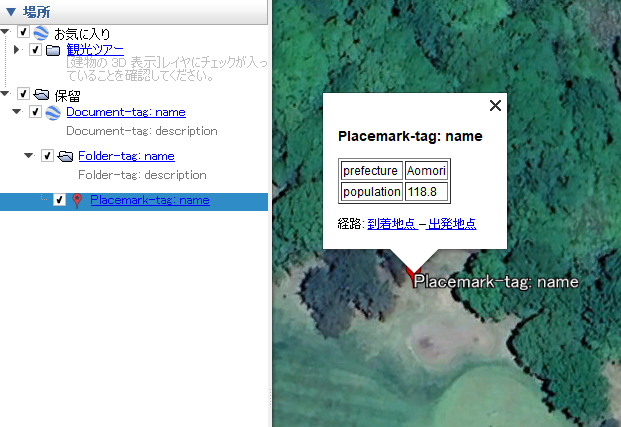

In [2]:
Image("..\\images\\session8\\kml_tags.png")

### **2-3. Styling**
kml ではデータの中に`Style`タグを設定し、表示するジオメトリーの色や形状を設定する事ができます。また、今回はやりませんが、マウスオーバーした時に別な色を表示する方法もあります。'Style'タグも入れ子構造であり、この中に`IconStyle`や`LineStyle`、`PolyStyle`タグを記述してスタイルを設定します。設定した Styleを適用する方法には2種類あり、使用する'Style'を適用したい'Placemark'の中で"Style ID"を指定するか、あるいは'Placemark'の中に'Style'タグを入れる方法があります。

今回は'Point'のデータのデータを使用しますので `IconStyle`タグを使用し、ID を使用する方法を使います。'Style'タグ内では色も指定可能ですが注意が必要です。kmlは一般的な"RGB"ではなく"ABGR"で指定する必要があり、面倒ですが何かしらの関数を作成するのが良いでしょう。

```xml
[kml]
<Style id="STYLE_IDを入力">
    <IconStyle>
        <color>
            <!-- Alpha Blue Green Red (16進数) -->
            - ff0000ff = red = RGB: ff0000
            - ffff0000 = blue = RGB: 0000ff
            - ff008000 = green = RGB: 008000
        </color>
        <Icon>
            <!-- Icon URLなど -->
            <href>
                - デフォルトのピン: http://maps.google.com/mapfiles/kml/pushpin/ylw-pushpin.png
                - 二重丸: http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png
            </href>
        </Icon>
        ...
    </IconStyle>
    <!-- LabelStyle -->
    <!-- LineStyle -->
    <!-- PolylStyle -->
    ...
</Style>
```

In [3]:
def hex_to_abgr(hex_str: str, alpha: float = 1.0):
    """Convert hex to ABGR."""
    func = lambda v: f"{int(v * 255):x}".zfill(2)
    r, g, b, a = [func(v) for v in to_rgba(hex_str, alpha)]
    return ''.join([a, b, g, r])


# Create a style object.
style1 = fastkml.styles.Style(id='style1')

# Create an icon style object.
icon_style = fastkml.styles.IconStyle(
    color=hex_to_abgr('#dc143c', 0.7),
    # IconのURLは GoogleEarthなどで確認可能
    icon_href='http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
)
style1.styles.append(icon_style)

"""
この方法でも可能
style1 = fastkml.styles.Style(
    id='style1', 
    styles=[icon_style]
)
"""
print(style1.to_string(prettyprint=True))

<kml:Style xmlns:kml="http://www.opengis.net/kml/2.2" id="style1">
  <kml:IconStyle>
    <kml:color>b23c14dc</kml:color>
    <kml:Icon>
      <kml:href>http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png</kml:href>
    </kml:Icon>
  </kml:IconStyle>
</kml:Style>



### **2-4. Extended data**
地理空間データを扱う場合、データの要素も重要です。kml では `ExtendedData`タグを設定し、その中にデータの要素を記録します。記録した要素は GoogleEarth であれば、Geometry をクリックすれば、ポップアップにテーブルとして表示されます。今回は触れませんが、`description` タグを使用する事でポップアップの表示をカスタマイズする事も可能です。

```xml
<ExtendedData>
    <Data name="要素の名前。例）Prefecture">
        <value>
            <!-- 要素 -->
            例）青森
        </value>
        <display_name>
            <!-- Popupで表示される要素の名前 -->
            例）都道府県
        </display_name>
    </Data>
    ...
</ExtendedData>
```

In [4]:
data = [
    fastkml.data.Data(
        name='prefecture', 
        display_name='都道府県',
        value='青森'
    ),
    fastkml.data.Data(
        name='population', 
        display_name='人口',
        value='118.8', 
    ),
]
extended_data = fastkml.data.ExtendedData(elements=data)

print(extended_data.to_string(prettyprint=True))

<kml:ExtendedData xmlns:kml="http://www.opengis.net/kml/2.2">
  <kml:Data name="prefecture">
    <kml:displayName>都道府県</kml:displayName>
    <kml:value>青森</kml:value>
  </kml:Data>
  <kml:Data name="population">
    <kml:displayName>人口</kml:displayName>
    <kml:value>118.8</kml:value>
  </kml:Data>
</kml:ExtendedData>



### **2-5. Geometry**

Geometryは座標や投影方法などが格納されるタグで、以下の様な種類があります。

 - Point
    
    ... 経度、緯度、高度で定義される位置。

 - LineString

    ... 'LineString' は 'Point' の集合で定義される線分です。

 - LinearRing

    ... 'LinearRing' は 'Point' の集合で定義される閉合した線分であり、'Polygon' を構成する為に使用されます。

 - Polygon 
 
    ... 'Polygon' は 'LinerRing' で構成された外側の境界線（'OuterBoundaryIs'）と 内側の境界線（'InnerBoundaryIs'）で構成される区域です。この座標は時計回りで描く必要があります。

 - MultiGeometry 
 
    ... 複数の 'Geometry' を 1つの要素として関連付ける為に使用します。shapely の場合はこれが 'MultiPoint' や 'MultiLineString'、'MultiPolygon'になります。

この他にもリファレンスを見ると 'Track' や 'MultiTrack'、'Model' などがあるようです。今回は 'Point' のデータを扱います。

```xml

<Point>
    <!-- 1つの経緯度と標高を定義します。 -->
    <extrude>
        <!-- 地面に接続するかどうか -->
        - 0 = False
        - 1 = True
    </extrude>
    <altitudeMode>
        <!-- 標高の扱い方を定義（不要） -->
            - clampToGround ... 高度指定を無視
            - relativeToGround ... 実際の高度に対して相対的に設定
            - absolute ... 海面を基準にして座標の標高を設定
    </altitudeMode>
    <coordinates>
        <!-- 経度,緯度,標高の順で格納します（必須） -->
        例1) 140.00000,40.00000
        例2) 140.00000,40.00000,100.00
    </coordinates>
</Point>
```


In [5]:
"""
python で扱う場合は shapely で Geometry を扱う場合も多いので（geopandasなど）今回は
それを想定しています。shapely で作成した Geometry を fastkml で扱う場合は、
pygeoif で変換すると良いでしょう。
"""
# shapely.geometry -> pygeoif.geometry
shapely_pnt = shapely.geometry.Point([140.46548586134475, 40.607494091524444])
pygeoif_pnt = pygeoif.shape(shapely_pnt)

# <Point>タグの作成
pnt = fastkml.geometry.create_kml_geometry(
    extrude=False,
    altitude_mode=fastkml.geometry.AltitudeMode.clamp_to_ground,
    geometry=pygeoif_pnt, # pygeoif の Geometry オブジェクトをそのまま渡す
)

print(pnt.to_string(prettyprint=True))

<kml:Point xmlns:kml="http://www.opengis.net/kml/2.2">
  <kml:extrude>0</kml:extrude>
  <kml:altitudeMode>clampToGround</kml:altitudeMode>
  <kml:coordinates>140.46548586134475,40.607494091524444</kml:coordinates>
</kml:Point>



### **2-6. Placemark**

'Placemark'タグは個々の Geometry や要素、スタイルを格納したタグです。'Placemark' は格納できる要素が多いので、ここでは今回関係する一部しか紹介しませんので、気になる方はリファレンスを参照してください。

```xml
<Placemark id="ID">
    <name>
        <!-- GoogleEarthであればサイドバーに表示される名前 -->
    </name>
    <styleUrl>
        <!-- 参照したいスタイルタグのID -->
    </styleUrl>
    <description>
        <!-- HTMLでポップアップをカスタムしたい場合はここに記述 -->
        <!-- このタグを追加すると、ExtendedDataが表示されないので注意 -->
    </description>
    <ExtendedData>
        <Data>...</Data>
    </ExtendedData>
    <Point>
        ...
    </Point>
    ...
</Placemark>
```

In [6]:
placemark = fastkml.kml.Placemark(
    id='Placemark-tag: id',
    # Pointのラベルとして表示される情報。
    name='Placemark-tag: name',
    # ポップアップで表示される情報
    extended_data=extended_data,
    # 今回は'Style'タグのIDを指定していますが、'Style'タグを直接格納することも可能です
    style_url=fastkml.styles.StyleUrl(url=f"#{style1.id}"),
    kml_geometry=pnt,
)

print(placemark.to_string(prettyprint=True))

<kml:Placemark xmlns:kml="http://www.opengis.net/kml/2.2" id="Placemark-tag: id">
  <kml:name>Placemark-tag: name</kml:name>
  <kml:styleUrl>#style1</kml:styleUrl>
  <kml:ExtendedData>
    <kml:Data name="prefecture">
      <kml:displayName>都道府県</kml:displayName>
      <kml:value>青森</kml:value>
    </kml:Data>
    <kml:Data name="population">
      <kml:displayName>人口</kml:displayName>
      <kml:value>118.8</kml:value>
    </kml:Data>
  </kml:ExtendedData>
  <kml:Point>
    <kml:extrude>0</kml:extrude>
    <kml:altitudeMode>clampToGround</kml:altitudeMode>
    <kml:coordinates>140.46548586134475,40.607494091524444</kml:coordinates>
  </kml:Point>
</kml:Placemark>



### **2-7. KML Object の作成**

KMLオブジェクトは `fastkml.KML()` で作成します。タグを追加したい場合はこのオブジェクトをベースとして`append`メソッドで追加していきます。`append`メソッドはいい感じにフォーマットしてくれる訳ではないので、ベースのオブジェクトに追加するデータの順番には注意が必要になります。

In [7]:
kml = fastkml.KML()

doc = fastkml.containers.Document(
    id='Document-tag: id', 
    # name(str): Google Earthで見る場合はデータの名前として表示される。
    name='Document-tag: name', 
    # description(str): Google Earthで見る場合はデータの説明として、名前の下に表示される。
    description='Document-tag: description'
)

folder = fastkml.containers.Folder(
    id='Folder-tag: id', 
    name='Folder-tag: name', 
    description='Folder-tag: description'
)

folder.append(style1)
folder.append(placemark)
doc.append(folder)
kml.append(doc)

print(kml.to_string(prettyprint=True))

<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document id="Document-tag: id">
    <name>Document-tag: name</name>
    <description>Document-tag: description</description>
    <Folder id="Folder-tag: id">
      <name>Folder-tag: name</name>
      <description>Folder-tag: description</description>
      <Style id="style1">
        <IconStyle>
          <color>b23c14dc</color>
          <Icon>
            <href>http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png</href>
          </Icon>
        </IconStyle>
      </Style>
      <Placemark id="Placemark-tag: id">
        <name>Placemark-tag: name</name>
        <styleUrl>#style1</styleUrl>
        <ExtendedData>
          <Data name="prefecture">
            <displayName>都道府県</displayName>
            <value>青森</value>
          </Data>
          <Data name="population">
            <displayName>人口</displayName>
            <value>118.8</value>
          </Data>
        </ExtendedData>
        <Point>
          <extrude>0</ex

In [9]:
# import pathlib 
# # データを保存するファイルパスは pathlib.Path オブジェクトで指定する必要がある
# file_path = pathlib.Path(r"C:\Users\makis\Downloads\sample.kml")

# kml.write(file_path, prettyprint=True, precision=10)